In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import matplotlib.pyplot as plt

from prediction import LtrPrediction
from processing import DataPreprocessing
import ltr_utils as ut

## Datasets

In [2]:
train = pd.read_csv("../Dataset/train.csv")
test = pd.read_csv("../Dataset/test.csv")
articles = pd.read_csv("../Dataset/Published_online_articles.csv")
users = pd.read_csv("../Dataset/subscribers.csv")

## Data Preprocessing

In [3]:
data_dict = {
    'train' : '../Dataset/train.csv',
    'test' : '../Dataset/test.csv',
    'articles' : '../Dataset/Published_online_articles.csv',
    'users' : '../Dataset/subscribers.csv'
}

In [4]:
DataPrep = DataPreprocessing(data_dict)

(11020, 19) (25672, 19)


In [5]:
DataPrep.init_KG('outputs/KGs/KG_dep_parsing_100terms.txt')

In [6]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 25672/25672 [04:39<00:00, 91.90it/s] 
/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 11020/11020 [01:59<00:00, 92.55it/s] 
/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [8]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [9]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [10]:
xgb_params = {  'booster':"gbtree", 
                'objective':"rank:pairwise",
                'tree_method':"gpu_hist", 
                'sampling_method':"gradient_based",
                'eval_metric':['map@10'],
             }

model = xgb.XGBRanker(**xgb_params)


model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)

result = model.evals_result()
train_score = np.mean(result['validation_0']['map@10'])
test_score = np.mean(result['validation_1']['map@10'])
print('default Train :  ', train_score)
print('default Test  :  ', test_score)

default Train :   0.4099463665895728
default Test  :   0.19626496216017


## Hyperparameter Tuning

In [11]:
def objective(trial):

        metric = "map@10"

        tuning_params = {
                    "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
                    "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.05),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.05),
                    "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, step=0.01),
                    "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0, step=0.01),
                    "gamma": trial.suggest_float("gamma", 0.01, 10.0, step=0.01),
                    "max_delta_step":  trial.suggest_float("max_delta_step", 0.01, 10.0, step=0.01),
                    "eta": trial.suggest_float("eta", 0.001, 10.0, step=0.001)

                }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-map@10")

        model = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                            tree_method="gpu_hist", sampling_method="gradient_based",
                            eval_metric=metric,
                            verbosity=1,
                            n_estimators=5000,
                            **tuning_params)

        model.fit(X_train, y_train, group=groups_train, eval_set=[(X_test, y_test)],early_stopping_rounds = 100,  eval_group=[groups_test], callbacks=[pruning_callback],  verbose=False)

        result = model.evals_result()
        opt_score1 = np.mean(result['validation_0'][metric])

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return opt_score1

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=500)

/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


In [12]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.2815
Best params:
	max_depth: 2
	subsample: 0.5
	colsample_bytree: 0.8
	reg_lambda: 9.53
	alpha: 0.1930625073674806
	min_child_weight: 6.27
	gamma: 6.85
	max_delta_step: 4.9399999999999995
	eta: 0.292


In [13]:
metric = "map@10"

model_bst = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                        tree_method="gpu_hist", sampling_method="gradient_based",
                        eval_metric=metric,
                        n_estimators=5000,
                        early_stopping_rounds = 50, 
                        verbosity=0,
                        **study.best_params)

model_bst.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)
result = model_bst.evals_result()
train_score = np.max(result['validation_0']['map@10'])
test_score = np.max(result['validation_1']['map@10'])
print('Optimized Train :  ', train_score)
print('Optimized Test  :  ', test_score)

Optimized Train :   0.2572769283335648
Optimized Test  :   0.3017565635565482


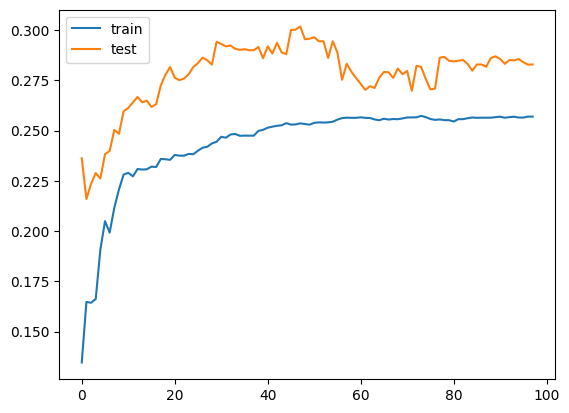

In [14]:
# plot learning curves
pyplot.plot(result['validation_0']['map@10'], label='train')
pyplot.plot(result['validation_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

In [26]:
path = 'outputs/kg_DP/'
ut.model_save(model_bst,path,DataPrep)

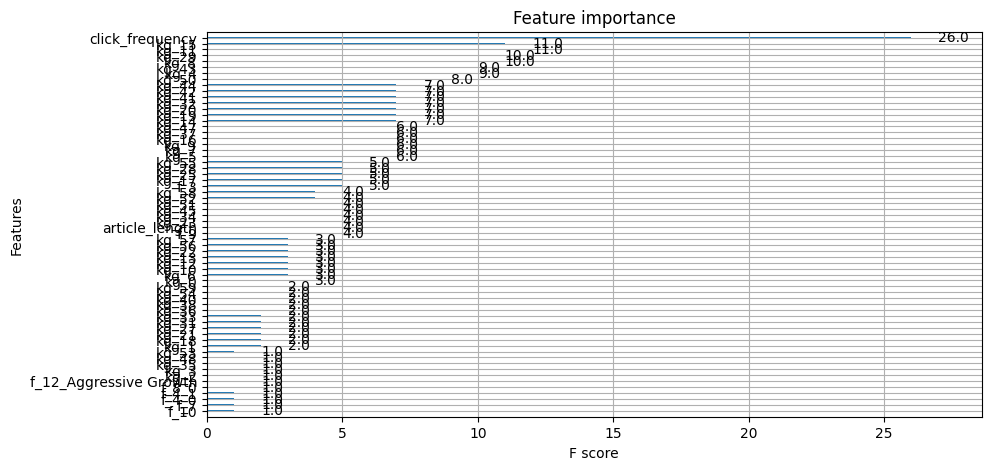

In [15]:
xgb.plot_importance(model_bst)
plt.show()

## Model Evaluation

In [ ]:
path = 'outputs/kg_DP1/'

model_bst, DataPrep = ut.load_model(path)

processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

In [16]:
xgb_Prediction = LtrPrediction(model_bst, test_data)

In [17]:
results = xgb_Prediction.evaluate()
results

NDCG=0.497 | Recall=0.696 | Precision=0.946 


{'MAP@10': 0.3416669095621787,
 'results@10': {'NDCG': 0.4970777795322848,
  'Recall': 0.6957749766573297,
  'Precision': 0.23006535947712417}}

In [18]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [19]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [ ]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

## SHAP

In [21]:
import shap

In [22]:
explainer = shap.Explainer(model_bst)
shap_values = explainer(X_train)

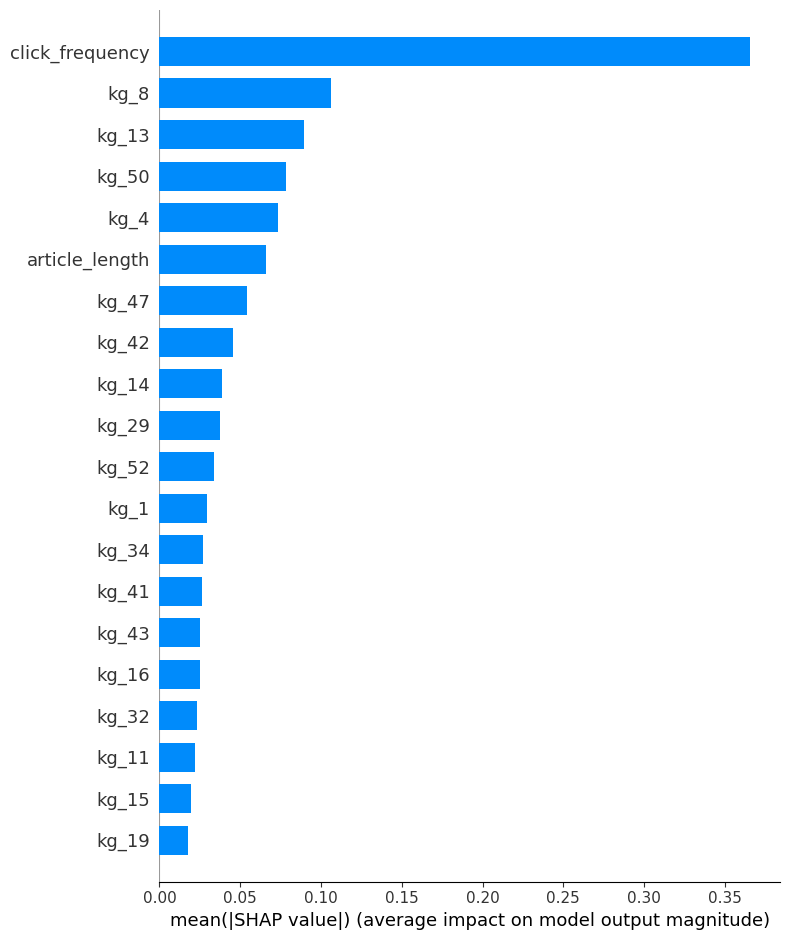

In [23]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## ELI5

In [24]:
from eli5.xgboost import explain_weights_xgboost

In [25]:
explain_weights_xgboost(model_bst)

Weight,Feature
0.1310,kg_13
0.1038,kg_1
0.0766,click_frequency
0.0553,article_length
0.0388,kg_34
0.0371,kg_8
0.0362,kg_50
0.0260,kg_47
0.0190,kg_4
0.0183,kg_42
